# 巴特沃斯高通滤波器

In [64]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from pyexcel_xls import get_data

In [65]:
'''
% 巴特沃斯带阻滤波器
% input:
%     滤波器的类型，‘btw’
%     M,N:频域滤波器的尺寸
%     D0：带阻滤波器的截止频率
%     n:巴特沃斯滤波器的阶数
% output:
%       H：M xN的矩阵，表示频域滤波器矩阵，数据类型为double，
'''
def freqfilter_btw(M,N,D0,n=1):
    u = np.arange(-M // 2,M // 2)
    v = np.arange(-N // 2,N // 2)
    U,V = np.meshgrid(u,v)
    D = np.sqrt(((U-M//2) ** 2 + (V-N//2) ** 2))
    H = np.zeros_like(D)
    eps = 1.0e-5
    H = 1.0 / (1 + 0.414 * (D0 / (D+eps) ** (2 * n)))
    #H = 1.0 / (1.0 + (D * W / (D ** 2 - D0 ** 2 + eps)) ** (2 * n))
    return H

In [66]:
'''
% 巴特沃斯高通滤波器
% input:
%     M,N:频域滤波器的尺寸
%     D0：带阻滤波器的截止频率
%     n ：阶次
% output:
%       H：M x N的矩阵，表示频域滤波器矩阵，数据类型为double，
'''
def freqfilter_btw_Hp(src,D0,n = 1):
    src_f = src.astype('float64') / 255.0
    # 傅立叶变换 
    img_fft = np.fft.fft2(src_f)
    img_fftshift = np.fft.fftshift(img_fft)
    
    rows,cols = src.shape
    H = freqfilter_btw(cols,rows,D0,n)
    idx = (H == 0)
    result = np.zeros_like(img_fftshift)
    result[idx] = 0
    result[~idx] = H[~idx] * img_fftshift[~idx]
    result = np.fft.ifftshift(result)
    result_ifft = np.fft.ifft2(result)
    dst = np.abs(result_ifft) * 255.0
    dst[dst < 0] = 0
    dst[dst > 255] = 255
    return dst.astype(np.uint8)

In [67]:
def freqfilter_btw_Hp2(src,D0,n=1):
    src_f = src.astype('float64') / 255.0
    # 傅立叶变换 
    img_fft = np.fft.fft2(src_f)
    img_fftshift = np.fft.fftshift(img_fft)
    
    rows,cols = src.shape
    n1 = rows // 2
    n2 = cols // 2
    result = np.zeros_like(img_fft)
    for i in range(rows):
        for j in range(cols):
            h = 0
            d = np.sqrt((i - n1) ** 2 + (j - n2) ** 2)
            if d == 0:
                h = 0
            else:
                h = 1.0 / (1.0 + 0.414 * (D0 / d) ** (2 * n))
            result[i,j] = h * img_fftshift[i,j]
    
    result = np.fft.ifftshift(result)
    result_ifft = np.fft.ifft2(result)
    dst = np.abs(result_ifft) * 255.0
    dst[dst < 0] = 0
    dst[dst > 255] = 255
    return dst.astype(np.uint8)

In [68]:
def noise_gaussian(M,N,a = 0,b=1):
    R = a + b * np.random.randn(M,N)
    return R

In [69]:
src = cv2.cvtColor(cv2.imread('../../datas/f3.jpg'),cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(src,cv2.COLOR_RGB2GRAY)

In [70]:
rows,cols = gray.shape
noise = noise_gaussian(rows,cols,a=0,b=0.1)
src_noise_gray = gray.astype(np.float32) + noise * 255

src_noise = np.zeros(src.shape,dtype=np.float64)
src_noise[:,:,0] = np.float64(src[:,:,0]) + noise * 255
src_noise[:,:,1] = np.float64(src[:,:,1]) + noise * 255
src_noise[:,:,2] = np.float64(src[:,:,2]) + noise * 255

src_noise[src_noise < 0] = 0
src_noise[src_noise > 255] = 255
src_noise = src_noise.astype(np.uint8)

In [71]:
dstr = freqfilter_btw_Hp(src_noise[:,:,0].astype(np.float32) ,4,3) 
dstg = freqfilter_btw_Hp(src_noise[:,:,1].astype(np.float32), 4,3)
dstb = freqfilter_btw_Hp(src_noise[:,:,2].astype(np.float32), 4,3)

In [72]:
dst = cv2.merge([dstr,dstg,dstb]).astype('uint8')

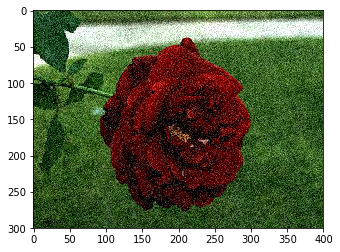

In [73]:
plt.imshow(src_noise)

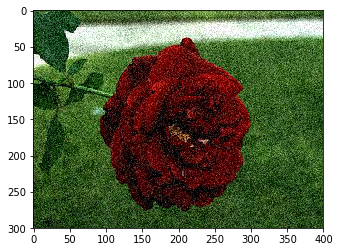

In [74]:
plt.imshow(dst)

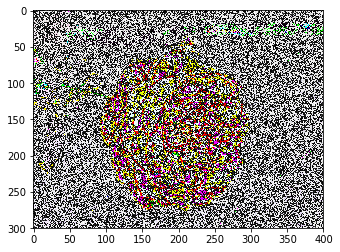

In [75]:
plt.imshow(np.abs(dst - src))

In [79]:
dstr2 = freqfilter_btw_Hp2(src_noise[:,:,0].astype(np.float32) ,4,2) 
dstg2 = freqfilter_btw_Hp2(src_noise[:,:,1].astype(np.float32), 4,2)
dstb2 = freqfilter_btw_Hp2(src_noise[:,:,2].astype(np.float32), 4,2)

In [80]:
dst2 = cv2.merge([dstr2,dstg2,dstb2]).astype('uint8')

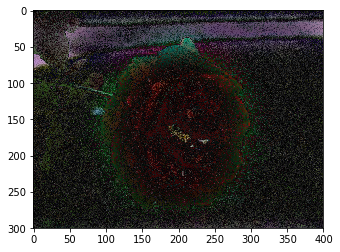

In [81]:
plt.imshow(dst2)